## Assignment 3a - Task 2: Collaborative Filtering

### Rizal Hamdan Arigusti, a1939989, Version 01
### Group 14

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load Dataset

In [19]:
dataframe = pd.read_csv("../../data/Groceries data train.csv")
dataframe = dataframe.rename(columns={"User_id": "user_id", "Date": "date","itemDescription": "item_description"})

In [20]:
dataframe = dataframe.dropna(how='all')
dataframe['date'] = pd.to_datetime(dataframe['date'], format="%d/%m/%Y")
missing_per_column = dataframe.isnull().sum()
print("Missing values per column:\n", missing_per_column)

Missing values per column:
 user_id             0
date                0
item_description    0
year                0
month               0
day                 0
day_of_week         0
dtype: int64


In [21]:
def generate_transaction_history(dataset):
    transaction_history = dataset.groupby(['user_id', 'date', "year", "month", "day", "day_of_week"]).agg({
        'item_description': list
    }).reset_index()

    transaction_history = transaction_history.rename(columns={"item_description": "items"})
    return transaction_history

full_transaction_history = generate_transaction_history(dataframe)

### 2. Exploratory Data Analyis

#### 2.1 User-Items Ratio and Sparsity Check

In [22]:
n_users = dataframe["user_id"].nunique()
n_items = dataframe["item_description"].nunique()

n_interactions = dataframe.groupby(["user_id", "item_description"]).size().shape[0]
n_possible_interactions = n_users * n_items

density = n_interactions / n_possible_interactions
sparsity = 1 - density


print(f"Sparsity: {sparsity:.2f}")
print(f"Density: {density:.2f}")
print("=" * 25)
print(f"Number of Users: {n_users}")
print(f"Number of Items: {n_items}")
print(f"User-Item Ratio: {n_users/n_items:.2f}")

Sparsity: 0.97
Density: 0.03
Number of Users: 3493
Number of Items: 167
User-Item Ratio: 20.92


#### 2.2 Number of Transaction of Each User

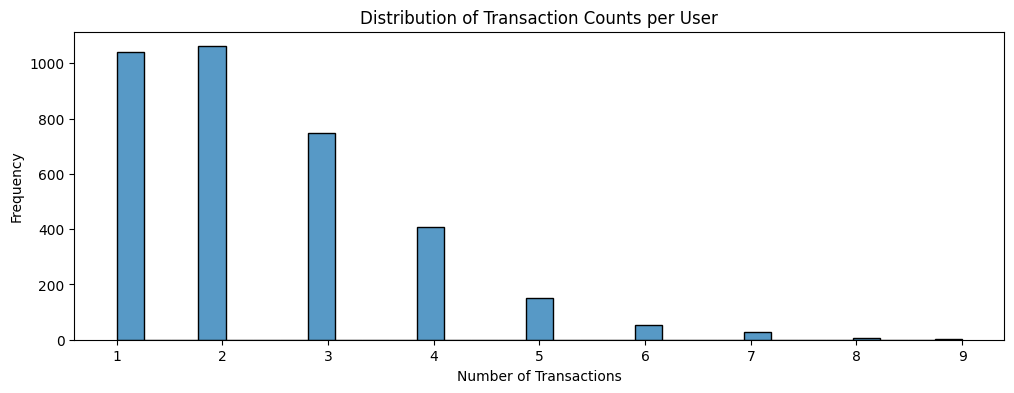

In [37]:
transaction_counts = full_transaction_history.groupby('user_id').size().reset_index(name='transaction_count')
plt.figure(figsize=(12, 4))
sns.histplot(transaction_counts['transaction_count'])
plt.title('Distribution of Transaction Counts per User')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

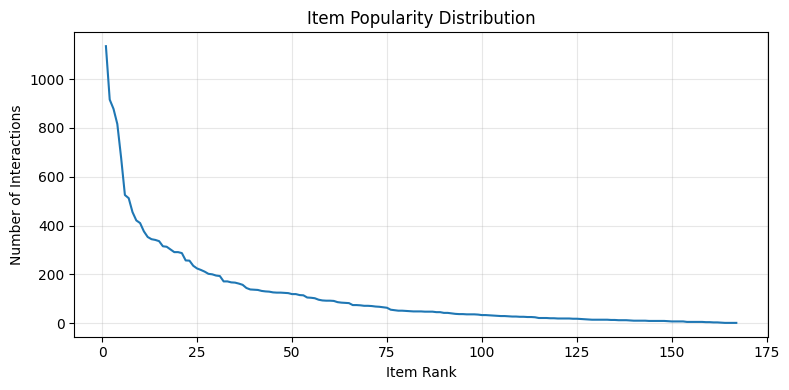

In [24]:
### Reference: ChatGPT 1

item_counts = dataframe['item_description'].value_counts().reset_index()
item_counts.columns = ['item_description', 'transaction_count']

# Sort by interaction count (descending)
item_counts = item_counts.sort_values('transaction_count', ascending=False)

# Add rank column
item_counts['rank'] = range(1, len(item_counts) + 1)

# Basic plot of interactions by item (ordered by popularity)
plt.figure(figsize=(8, 4))
plt.plot(item_counts['rank'], item_counts['transaction_count'])
plt.title('Item Popularity Distribution')
plt.xlabel('Item Rank')
plt.ylabel('Number of Interactions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

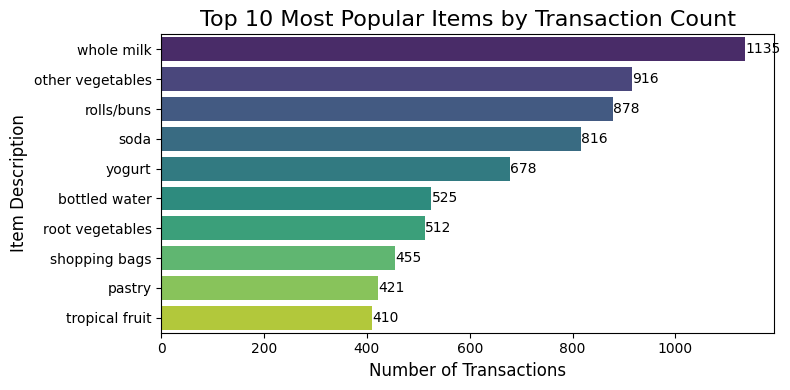

In [25]:
top_10_items = item_counts.head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x='transaction_count', y='item_description', data=top_10_items, palette='viridis', hue='item_description')

plt.title('Top 10 Most Popular Items by Transaction Count', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Item Description', fontsize=12)

for i, v in enumerate(top_10_items['transaction_count']):
    plt.text(v + 0.5, i, str(v), va='center')

plt.tight_layout()
plt.show()

### 3. Preprocessing

In [26]:
def split_dataset_by_date(df, ratio):
    df = df.sort_values("date")
    total_rows = len(df)
    target_split = int(total_rows * ratio)
    cumulative_count = 0
    for date, count in df['date'].value_counts().sort_index().items():
        cumulative_count += count
        if cumulative_count >= target_split:
            split_date = pd.to_datetime(date)
            train = df[df['date'] < split_date]
            dev = df[df['date'] >= split_date]
            return train, dev, split_date
    return df, pd.DataFrame(), None


In [27]:
def split_dataset(dataset, train_size=0.8):
    total = len(dataset)
    train_end_exclusive = int(total * train_size)

    dates = dataset[["date"]]
    is_same_date = True
    while is_same_date:
        train_end_inclusive = train_end_exclusive - 1
        if dates.iloc[train_end_inclusive].values[0] != dates.iloc[train_end_inclusive + 1].values[0]:
            is_same_date = False
            break
        train_end_exclusive += 1
    
    train_set = dataset.iloc[:train_end_exclusive]
    dev_set = dataset.iloc[train_end_exclusive:]
    
    return train_set, dev_set

In [28]:
train_set, dev_set, split_date = split_dataset_by_date(dataframe, ratio=0.7)

In [29]:
def generate_transaction_history(dataset):
    transaction_history = dataset.groupby(['user_id', 'date', "year", "month", "day", "day_of_week"]).agg({
        'item_description': list
    }).reset_index()

    transaction_history = transaction_history.rename(columns={"item_description": "items"})
    return transaction_history

train_transaction_history = generate_transaction_history(train_set)

#### 3.1 Generate Utility Matrix

In [30]:
def generate_utility_matrix(dataset):
    utility_matrix = pd.crosstab(dataset['user_id'].astype(int), dataset['item_description'])
    utility_matrix.replace(0, np.nan, inplace=True)
    return utility_matrix

In [31]:
train_utility_matrix = generate_utility_matrix(train_set)
dev_utility_matrix = generate_utility_matrix(dev_set)

In [32]:
def mean_norm(array):
    # print(type(array))
    mean = np.mean(array)
    norm_array = [freq - mean for freq in array]
    return pd.Series(norm_array, index=array.index), mean


def normalize_utility_matrix(utility_matrix, type="item"):
    axis = 0 if type == "item" else 1
    mean_dict = {}
    
    def apply_mean_norm(x):
        norm_x, mean = mean_norm(x)
        mean_dict[x.name] = mean  # Store the mean for this item/user
        return norm_x
        
    utility_matrix_normalized = utility_matrix.apply(apply_mean_norm, axis=axis)
    return utility_matrix_normalized, pd.Series(mean_dict)
    

In [33]:
train_norm_utility_matrix_item_based, train_set_means_item_based = normalize_utility_matrix(train_utility_matrix.copy()) 
train_norm_utility_matrix_item_based

item_description,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
user_id,,,,,,,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149341,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149341,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149341,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.850659,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149341,NaN,NaN


### 4. Collaborative Filtering

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

def predict_rating(item_similarity_matrix, utility_matrix, user_purchased_items, target_user, target_item, n_neighbour=10):
    similar_items = item_similarity_matrix[target_item].drop(index=target_item)
    top_k_items = similar_items.sort_values(ascending=False).head(n_neighbour)
    
    weighted_sum = 0
    similarity_sum = 0
    
    if len(user_purchased_items) < 1:
        return  utility_matrix[target_item].mean() 
    
    for item, similarity in top_k_items.items():
        if item in user_purchased_items:
            rating = utility_matrix.loc[target_user, item]
            if not np.isnan(rating):
                weighted_sum += similarity * rating
                if similarity > 0:
                    similarity_sum += similarity

    return weighted_sum / similarity_sum if similarity_sum != 0 else 0

def generate_item_similarity_table(utility_matrix):
    filled_matrix = utility_matrix.fillna(0).T
    
    similarity_matrix = cosine_similarity(filled_matrix)
    
    similarity_df = pd.DataFrame(similarity_matrix, 
                                 index=filled_matrix.index, 
                                 columns=filled_matrix.index)
    
    return similarity_df

In [42]:
def get_cf_recommended_items(target_user, 
                             utility_matrix,
                             item_similarity_matrix,
                             n_recommended_items=None, 
                             n_similar_neighbours = 10,
                             debug=False):
    
        all_user_ids = utility_matrix.index   
        user_unpurchased_items = []
        user_purchased_items = []
        if not target_user in all_user_ids:
            if debug:
                print("New User:", target_user)
            user_unpurchased_items = utility_matrix.columns 
        else:
            user_ratings_row = utility_matrix.loc[target_user]
            user_unpurchased_items = user_ratings_row[user_ratings_row.isna()].index.tolist()
            user_purchased_items = user_ratings_row[~user_ratings_row.isna()].index.tolist()
            
        rating_predictions = {}
        for target_item in user_unpurchased_items:
            predicted_rating = predict_rating(item_similarity_matrix, 
                                                     utility_matrix, 
                                                     user_purchased_items, 
                                                     target_user, 
                                                     target_item,
                                                     n_similar_neighbours,
                                                     )
            rating_predictions[target_item] = predicted_rating
        
        recommended_items = sorted(rating_predictions.items(), key=lambda x: x[1], reverse=True)
        if not n_recommended_items:
            return recommended_items
        return recommended_items[:n_recommended_items]

In [43]:
item_based_similarity_matrix = generate_item_similarity_table(train_norm_utility_matrix_item_based)
based_cf_recommendation = get_cf_recommended_items(1050, 
                                                   train_utility_matrix, 
                                                   item_based_similarity_matrix, 
                                                   n_recommended_items=10, 
                                                   debug=True)
based_cf_recommendation

[('UHT-milk', 2.0),
 ('canned beer', 2.0),
 ('citrus fruit', 2.0),
 ('dessert', 2.0),
 ('ham', 2.0),
 ('mustard', 2.0),
 ('onions', 2.0),
 ('rolls/buns', 2.0),
 ('sausage', 2.0),
 ('soda', 2.0)]

### 5. References

ChatGPT 1: OpenAI 2025 ChatGPT v4.o, "example item popularity distribution", Appendix A

### 6. Appendix

#### Appendix A

```
import pandas as pd
import matplotlib.pyplot as plt

# Example: replace with your actual data
data = {
    'user_id': [1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 6],
    'item_id': ['A', 'B', 'A', 'C', 'A', 'B', 'D', 'E', 'F', 'A', 'B']
}

# Create DataFrame
df = pd.DataFrame(data)

# Count the number of interactions per item
item_counts = df['item_id'].value_counts()

# Sort by popularity (descending) and reset index
item_counts_sorted = item_counts.sort_values(ascending=False).reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(item_counts_sorted.values)
plt.title("Item Popularity Distribution")
plt.xlabel("Item Rank")
plt.ylabel("Number of Interactions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

```